In [ ]:
import pickle
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt


# the class Minimum stores minimum points found according to their structure
class Minimum:
    threshold = 10**-6

    def __init__(self, vals, p, max_dist, grad_norm, norm_sum):
        self.vals = vals
        self.p = p
        self.multiplicity = 1
        self.max_dist = max_dist
        self.min_eig = -np.inf
        self.block_eigs = None
        self.pred_eigs = None
        self.grad_norm = grad_norm
        self.norm_sum = norm_sum

In [ ]:
# adds a new minimum to the list of minima. If the minimum was already encountered then the multiplicity is incremented,
# otherwise the point is added as a new item in the list
def add_minimum(minima, W, vals, p, max_dist, grad_norm, norm_sum):
    found = False
    for minimum in minima:
        dist = LA.norm(reconstruct_matrix(minimum.vals, minimum.p) - W)
        if not found and np.array_equal(minimum.p, p) and dist < minimum.threshold:
            minimum.multiplicity += 1
            minimum.max_dist = max(minimum.max_dist, dist)
            found = True
    if not found:
        minima.append(Minimum(vals=vals, p=p, max_dist=max_dist, grad_norm=grad_norm, norm_sum=norm_sum))
    return minima


In [ ]:
# compute the gradient of the objective at point 'W' with respect to standard basis target vectors V
def grad(W):
    V = np.identity(W.shape[0])
    Wnorms = LA.norm(W, axis=0)
    Vnorms = np.ones((Wnorms.shape[0],))
    Wnormalized = W / np.expand_dims(Wnorms, 0)
    anglesWW = np.arccos(np.clip(np.dot(np.transpose(Wnormalized), Wnormalized), -1, 1))
    anglesWV = np.arccos(np.clip(Wnormalized, -1, 1))
    gWW = np.dot(Wnorms, np.sin(anglesWW)) * Wnormalized + np.dot(W, (np.pi - anglesWW))
    gWV = np.dot(Vnorms, np.sin(anglesWV)) * Wnormalized + np.dot(V, (np.pi - anglesWV))
    return (gWW - gWV)*0.5/np.pi

In [ ]:
# performs gradient descent on the objective starting from point 'W' and using a step size of 'step' till the gradient
# norm is at most 'target_norm'
def find_minimum(W, target_norm, step=None):
    if step is None:
        step = 5/W.shape[0]
    g = grad(W)
    count = 0
    while LA.norm(g, 'fro') > target_norm:
        count += 1
        W = W-step*g
        g = grad(W)
        #if np.remainder(count, 100) == 0:
        #    print('Iteration: ' + str(count) + '. Fro norm: ' + str(LA.norm(g, 'fro')))
    return W

In [ ]:
# compute an upper bound on the smallest eigenvalue of the diagonal block component H_{i,i}', which is used in the
# proof of Theorem 4.1
def pred_eig(W, i):
    Wnorms = LA.norm(W, axis=0)
    Wnormalized = W / np.expand_dims(Wnorms, 0)
    np.set_printoptions(precision=3)
    np.set_printoptions(suppress=True)
    anglesWW = np.arccos(np.clip(np.dot(np.transpose(Wnormalized)[i, :], Wnormalized), -1, 1))
    anglesWV = np.arccos(np.clip(Wnormalized[:, i], -1, 1))
    return (np.dot(Wnorms, np.sin(anglesWW)) - np.sum(np.sin(anglesWV)))*0.5/(np.pi * Wnorms[i])


In [ ]:
# compute the h1 Hessian component
def h1(w, v):
    wnorm = w/LA.norm(w)
    vnorm = v/LA.norm(v)
    theta = np.arccos(max(min(np.dot(wnorm, vnorm), 1), -1))
    if theta == 0 or theta == np.pi:
        return np.zeros((w.shape[0], w.shape[0]))
    n = vnorm - np.cos(theta)*wnorm
    nnorm = n/LA.norm(n)
    return np.sin(theta)*LA.norm(v)/(2*np.pi*LA.norm(w))*(np.identity(w.shape[0]) - np.outer(wnorm, wnorm) + np.outer(nnorm, nnorm))

In [ ]:
# compute the h2 Hessian component
def h2(w, v):
    wnorm = w / LA.norm(w)
    vnorm = v / LA.norm(v)
    theta = np.arccos(max(min(np.dot(wnorm, vnorm), 1), -1))
    if theta == 0:
        return np.identity(w.shape[0])
    else:
        if theta == np.pi:
            return np.zeros((w.shape[0], w.shape[0]))
    nvw = vnorm - np.cos(theta) * wnorm
    nwv = wnorm - np.cos(theta) * vnorm
    nvwnorm = nvw / LA.norm(nvw)
    nwvnorm = nwv / LA.norm(nwv)
    return 1 / (2 * np.pi) * ((np.pi - theta)*np.identity(w.shape[0]) + np.outer(nwvnorm, vnorm) + np.outer(nvwnorm, wnorm))


In [ ]:
# compute the diagonal block component H_{i,i}' as defined in Section 4 in the paper
def hii(W, i):
    V = np.identity(W.shape[0])
    ans = np.zeros((W.shape[0], W.shape[0]))
    for j in range(W.shape[0]):
        ans -= h1(W[:, i], V[:, j])
        if i != j:
            ans += h1(W[:, i], W[:, j])
    return ans



In [ ]:
# compute the Hessian of the objective at given point 'W' with respect to standard basis target vectors V
def hess(W):
    d = W.shape[0]
    k = W.shape[1]
    ans = np.zeros((d*k, d*k))
    for i in range(k):
        ans[i*d:(i+1)*d, i*d:(i+1)*d] = 0.5*np.identity(d) + hii(W, i)
        for j in range(i+1, k):
            ans[i * d:(i + 1) * d, j * d:(j + 1) * d] = h2(W[:, i], W[:, j])
            ans[j * d:(j + 1) * d, i * d:(i + 1) * d] = ans[i * d:(i + 1) * d, j * d:(j + 1) * d]
    return ans

In [ ]:
# given the compressed representation of a minimum point, with distinct values 'vals' and block sizes 'p', reconstructs
# the k by k minimum point
def reconstruct_matrix(vals, p):
    if np.array_equal(vals, np.array([1, 0])):
        return np.identity(p[0])
    p = p.astype(int)
    k = np.sum(p)
    p = np.append([0], np.cumsum(p))
    W = np.zeros((k, k))
    for i in range(1, p.shape[0]):
        for j in range(1, p.shape[0]):
            if i == j:
                W[p[i-1]:p[i], p[i-1]:p[i]] = (vals[i-1, i-1] - vals[i-1, -1]) * np.identity(p[i]-p[i-1]) + vals[i-1, -1] * np.ones((p[i]-p[i-1], p[i]-p[i-1]))
            else:
                W[p[i - 1]:p[i], p[j - 1]:p[j]] = vals[i-1, j-1]
    return W


In [ ]:
def find_minima(max_k, instantiations, target_norm=10**-9):
    for k in range(6, max_k+1):
        try:
            minima = pickle.load(open("Converged minima k=" + str(k) + ".p", "rb"))
            if LA.norm(grad(minima[:, :, 0]), 'fro') > target_norm:
                minima[:, :, 0] = find_minimum(minima[:, :, 0], step=5/k, target_norm=target_norm)
                pickle.dump(minima, open("Converged minima k=" + str(k) + ".p", "wb"))
                print('Minimum found for k=' + str(k))
        except (OSError, IOError) as e:
            minima = np.zeros((k, k, 1))
            W = np.random.normal(size=(k, k)) / k ** 0.5  # Xavier initialization
            minima[:, :, 0] = find_minimum(W, step=5/k, target_norm=target_norm)
            pickle.dump(minima, open("Converged minima k=" + str(k) + ".p", "wb"))
            print('Minimum found for k=' + str(k))
    # now all files are created
    print('!!!!! Found 1 minimum for all k up to k=' + str(k) + ' !!!!!')
    for i in range(1, instantiations):
        for k in range(6, max_k + 1):
            V = np.identity(k)
            W = np.random.normal(size=(k, k)) / k ** 0.5  # Xavier initialization
            minima = pickle.load(open("Converged minima k=" + str(k) + ".p", "rb"))
            try:
                if LA.norm(grad(minima[:, :, i], V), 'fro') > target_norm:
                   minima[:, :, i] = find_minimum(minima[:, :, i], step = 5 / k, target_norm=target_norm)
                   pickle.dump(minima, open("Converged minima k=" + str(k) + ".p", "wb"))
                   print('Minimum found for k=' + str(k))
            except:
                minimum = np.zeros((k, k, 1))
                minimum[:, :, 0] = find_minimum(W, step=5 / k, target_norm=target_norm)
                minima = np.append(minima, minimum, axis=2)
                pickle.dump(minima, open("Converged minima k=" + str(k) + ".p", "wb"))
                print('Minimum found for k=' + str(k))
        print('!!!!! Found ' + str(i+1) + ' minima for all k up to k=' + str(k) + '!!!!!')

In [ ]:
# identify point found for k from min_k to max_k that are equivalent up to permutations of the neurons and coordinates
def process_minima(max_k, min_k=6):
    for k in range(min_k, max_k + 1):
        try:
            minima = pickle.load(open("Converged minima k=" + str(k) + ".p", "rb"))
            processed_minima = []
            for i in range(0, minima.shape[2]):
                dist = LA.norm(np.transpose(minima[:, :, i]) @ minima[:, :, i] - np.identity(k))
                if dist < 10 ** -6:
                    # point found is very close to a global minimum
                    add_minimum(minima=processed_minima, W=np.identity(k), vals=np.array([1, 0]), p=np.array([k]), max_dist=dist, grad_norm=0, norm_sum=k)
                else:
                    unique_vals = np.unique(np.round(minima[:, :, i].flatten(), decimals=4))  # extract the distinct
                    # (up to 4 digits) values of the entries in the point found, and identify the family of symmetries
                    # it possesses
                    P1 = np.zeros(minima[:, :, i].shape)
                    p = np.array([], dtype=int)
                    for val in unique_vals:  # identify the diagonal values in the point found. These values are always
                        # distinct in their row and column
                        rounded = np.round(minima[:, :, i], decimals=4)
                        rounded[rounded != val] = 0
                        rounded[rounded == val] = 1
                        if np.max(np.sum(rounded, axis=0)) == 1 and np.max(np.sum(rounded, axis=1)) == 1:
                            if np.sum(rounded) == 2:
                                # this is the case where there are exactly two values that are the same which are also
                                # distinct in their row and column. In such a case we cannot tell if these are the
                                # diagonal values or their off-diagonal entries are. Choose the entries with largest
                                # absolute value to be the diagonal entries.
                                idx = np.diag(np.argwhere(rounded == 1))
                                val2 = np.round(minima[idx[0], idx[1], i], decimals=4)
                                if np.abs(val) > np.abs(val2):
                                    P1[rounded == 1] = 1
                                    p = np.append(p, int(np.sum(rounded)))
                            else:
                                P1[rounded == 1] = 1
                                p = np.append(p, int(np.sum(rounded)))
                    # now multiplying the point found, minima[:, :, i], with the transpose of P1 from the left will
                    # result in a matrix where all the main diagonal values are on the main diagonal (but not necessarily sorted)
                    minima[:, :, i] = np.transpose(P1) @ minima[:, :, i]

                    # this next part extracts the diagonal values and sorts them to rearrange the point according to
                    # its symmetry properties
                    diag = np.diag(minima[:, :, i])
                    idx = np.argsort(diag)
                    P2 = np.identity(k)[:, idx]
                    W = np.transpose(P2) @ minima[:, :, i] @ P2
                    p = p[np.argsort(np.unique(np.round(np.diag(W), decimals=4)))]
                    p_sum = np.cumsum(np.append([0], p))[:-1]
                    vals = W[np.ix_(p_sum.astype(int), p_sum.astype(int))]
                    vals0 = np.zeros((p.shape[0], p.shape[0] + 1))
                    vals0[:vals.shape[0], :vals.shape[1]] = vals
                    vals = vals0
                    curr_j = int(0)
                    for j in range(p.shape[0]):
                        if p[j] > 1:
                            vals[j, -1] = W[curr_j, curr_j + 1]
                        curr_j += int(p[j])

                    # now, the variables 'vals' and 'p' store a compressed representation of the point found
                    Wtarget = reconstruct_matrix(vals, p)
                    add_minimum(minima=processed_minima, W=W, vals=vals, p=p, max_dist=LA.norm(W - Wtarget, 'fro'),
                                grad_norm=LA.norm(grad(Wtarget), 'fro'), norm_sum=np.sum(LA.norm(Wtarget, axis=0)))
            pickle.dump(processed_minima, open("Processed minima k=" + str(k) + ".p", "wb"))
            print('Finished processing minima for k=' + str(k))
        except (OSError, IOError) as e1:
            raise Exception('File "Converged minima k=' + str(k) + '.p" not found')


# compute the eigenvalues of the Hessian at the points found for k from 'min_k' to 'max_k'
def compute_eigs(max_k, min_k=6):
    for k in range(min_k, max_k+1):
        try:
            minima = pickle.load(open("Processed minima k=" + str(k) + ".p", "rb"))
        except (OSError, IOError) as e:
            raise Exception('File "Processed minima k=' + str(k) + '.p" not found')
        for i in range(len(minima)):
            if minima[i].min_eig == -np.inf:
                eigs, _ = LA.eigh(hess(reconstruct_matrix(minima[i].vals, minima[i].p)))
                minima[i].min_eig = np.min(eigs)
            pickle.dump(minima, open("Processed minima k=" + str(k) + ".p", "wb"))
        print('Finished computing eigenvalues for k=' + str(k))


# compute the eigenvalues of the diagonal block components H_{i,i}' as defined in Section 4 in the paper, for the point
# found for k from 'min_k' to 'max_k'
def compute_overparam_stats(max_k, min_k=6):
    for k in range(min_k, max_k+1):
        try:
            minima = pickle.load(open("Processed minima k=" + str(k) + ".p", "rb"))
        except (OSError, IOError) as e:
            raise Exception('File "Processed minima k=' + str(k) + '.p" not found')
        for i in range(len(minima)):
            if minima[i].pred_eigs is None:
                W = reconstruct_matrix(minima[i].vals, minima[i].p)
                p_idx = np.cumsum(np.append([0], minima[i].p))[:-1]
            if not np.array_equal(minima[i].vals, np.array([1, 0])):
                if minima[i].block_eigs is None:
                    block_eigs = np.array([])
                    for j in range(p_idx.shape[0]):
                        eigs, _ = LA.eigh(hii(W, p_idx[j]))
                        block_eigs = np.append(block_eigs, np.min(eigs))
                    minima[i].block_eigs = block_eigs
                if minima[i].pred_eigs is None:
                    pred_eigs = np.array([])
                    for j in range(p_idx.shape[0]):
                        pred_eigs = np.append(pred_eigs, pred_eig(W, p_idx[j]))
                    minima[i].pred_eigs = pred_eigs
            pickle.dump(minima, open("Processed minima k=" + str(k) + ".p", "wb"))
        print('Finished computing overparameterization statistics for k=' + str(k))



In [ ]:
# plot a histogram of the Euclidean norm sum of the neurons for the points found for k in {20,50,100}
def norm_graph():
    k = [20, 50,100]
    data = []
    for i in range(len(k)):
        try:
            minima = pickle.load(open("Processed minima k=" + str(k[i]) + ".p", "rb"))
        except (OSError, IOError) as e:
            err_msg = 'File "Processed minima k=' + str(k[i]) + '.p" not found'
            raise Exception(err_msg)
        data.append(np.array([]))
        for j in range(len(minima)):
            if not np.array_equal(minima[j].vals, np.array([1, 0])) and minima[j].min_eig > 0:
                data[i] = np.append(data[i], minima[j].norm_sum * np.ones((minima[j].multiplicity,)))

    f, (a1, a2, a3) = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(13, 6))

    a1.hist(data[0], bins=8)
    a1.set_xlim((19.98, 20))
    a1.ticklabel_format(useOffset=False)
    a1.set_title('k=20', fontsize=16)
    a1.tick_params(labelsize=14)
    a1.set_xticks(np.arange(19.98, 20.005, 0.01))

    a2.hist(data[1])
    a2.set_xlim((49.992, 50))
    a2.ticklabel_format(useOffset=False)
    a2.set_title('k=50', fontsize=16)
    a2.set_xlabel('Sum of Euclidean norm of neurons', fontsize=16)
    a2.tick_params(labelsize=14)
    a2.set_xticks(np.arange(49.992, 50.001, 0.004))

    a3.hist(data[2])
    a3.set_xlim((99.996, 100))
    a3.ticklabel_format(useOffset=False)
    a3.set_title('k=100', fontsize=16)
    a3.tick_params(labelsize=14)
    a3.set_xticks(np.arange(99.996, 100.001, 0.002))

    plt.show()

In [ ]:
# verify that the conditions in the paper hold. Specifically, assert that the norm sum is at most k, that the minimal
# eigenvalue is at least 10**-4 (so it's unlikely that the point is a saddle), and outputs the largest Frobenius
# distance between two points that were considered equivalent up to permutations
def verify_conditions(max_k, min_k=6):
    all_valid = True
    max_dist = 0
    for k in range(min_k, max_k + 1):
        try:
            minima = pickle.load(open("Processed minima k=" + str(k) + ".p", "rb"))
        except (OSError, IOError) as e:
            raise Exception('File "Processed minima k=' + str(k) + '.p" not found')
        for i in range(len(minima)):
            max_dist = max(max_dist, minima[i].max_dist)
            if len(minima[i].p) > 3:
                # found a point with more than 11 distinct entry values. All points found in practice for k<=100 have
                # 5,6 or 11 distinct entry values
                print('A point with 4 or more symmetries found for k=' + str(k) + ' at index i=' + str(i) + ' and p=' + str(minima[i].p))
            if minima[i].norm_sum == k:
                # found a global minimum. Interestingly, the global minimum is very rarely found once k>30
                print('Global minimum found for k=' + str(k) + ' at index i=' + str(i))
            if minima[i].norm_sum > k:
                # found a point violating the norm sum bound of k
                print('Point found for k=' + str(k) + ' at index i=' + str(i) + ' has norm ' + str(minima[i].norm_sum))
                all_valid = False
            if minima[i].min_eig <= 0.0001:
                # found a point which might not be a local minimum
                print('Point found for k=' + str(k) + ' at index i=' + str(i) + ' is a saddle')
                all_valid = False
    print('All points are equivalent up to Frobenius distance of ' + str(max_dist))
    if all_valid:
        print('All points found by GD are local minima which have a norm sum of at most k!')


np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

In [ ]:
# the following code runs a quick test for k up to 20 which should take about a minute to run

find_minima(20, instantiations=10, target_norm=10 ** -12)  # find 10 minima for each k from 6 to 20, with gradient norm at most 10**-12
process_minima(20)  # identify minima that are equivalent up to permutations of the neurons and coordinates
compute_overparam_stats(20)  # compute the eigenvalues of diagonal block components H_{i,i}' of the minima found
compute_eigs(20)  # compute the eigenvalues of the minima found, in particular allows us to verif y positive-definiteness
# using floating point computations
verify_conditions(20)  # assert that all minima have norm sum at most k and that all diagonal block components H_{i,i}'
# have a negative eigenvalue

Minimum found for k=6
Minimum found for k=7
Minimum found for k=8
Minimum found for k=9
Minimum found for k=10
Minimum found for k=11
Minimum found for k=12
Minimum found for k=13
Minimum found for k=14
Minimum found for k=15
Minimum found for k=16
Minimum found for k=17
Minimum found for k=18
Minimum found for k=19
Minimum found for k=20
!!!!! Found 1 minimum for all k up to k=20 !!!!!
Minimum found for k=6
Minimum found for k=7
Minimum found for k=8
Minimum found for k=9
Minimum found for k=10
Minimum found for k=11
Minimum found for k=12
Minimum found for k=13
Minimum found for k=14
Minimum found for k=15
Minimum found for k=16
Minimum found for k=17
Minimum found for k=18
Minimum found for k=19
Minimum found for k=20
!!!!! Found 2 minima for all k up to k=20!!!!!
Minimum found for k=6
Minimum found for k=7
Minimum found for k=8
Minimum found for k=9
Minimum found for k=10
Minimum found for k=11
Minimum found for k=12
Minimum found for k=13
Minimum found for k=14
Minimum found for k

In [ ]:
import pickle
import numpy as np

# Load file
with open('Converged minima k=6.p', 'rb') as f:
    minima = pickle.load(f)

print(minima.shape)  # Should be (6, 6, 10) if 10 instantiations
print(minima[:, :, 0])  # See the first minimum

with open('Processed minima k=6.p', 'rb') as f:
    processed_minima = pickle.load(f)

print(len(processed_minima))  # How many minima were processed
print(processed_minima[0].vals)  # See compressed matrix info of the first one
print(processed_minima[0].min_eig)  # See the minimum eigenvalue


(6, 6, 14)
[[ 0.  1.  0.  0.  0. -0.]
 [ 1. -0. -0. -0.  0. -0.]
 [ 0. -0.  0.  1.  0. -0.]
 [ 0. -0.  1. -0.  0. -0.]
 [ 0.  0.  0.  0. -0.  1.]
 [-0. -0. -0. -0.  1.  0.]]
1
[1 0]
0.09084505690810428


In [ ]:
import pickle
import numpy as np

# Load file
with open('Converged minima k=7.p', 'rb') as f:
    minima = pickle.load(f)

print(minima.shape)  # Should be (6, 6, 10) if 10 instantiations
print(minima[:, :, 0])  # See the first minimum

with open('Processed minima k=7.p', 'rb') as f:
    processed_minima = pickle.load(f)

print(len(processed_minima))  # How many minima were processed
print(processed_minima[0].vals)  # See compressed matrix info of the first one
print(processed_minima[0].min_eig)  # See the minimum eigenvalue



(7, 7, 14)
[[ 0. -0. -0.  0.  1. -0. -0.]
 [ 0.  0.  1. -0.  0.  0.  0.]
 [ 1. -0. -0.  0. -0. -0.  0.]
 [-0. -0. -0.  0.  0. -0.  1.]
 [ 0.  1. -0.  0.  0. -0.  0.]
 [ 0.  0. -0.  0.  0.  1.  0.]
 [-0. -0.  0.  1. -0. -0. -0.]]
1
[1 0]
0.0908450569081043


In [ ]:
import pickle
import numpy as np

# Load file
with open('Converged minima k=8.p', 'rb') as f:
    minima = pickle.load(f)

print(minima.shape)  # Should be (6, 6, 10) if 10 instantiations
print(minima[:, :, 0])  # See the first minimum

with open('Processed minima k=8.p', 'rb') as f:
    processed_minima = pickle.load(f)

print(len(processed_minima))  # How many minima were processed
print(processed_minima[0].vals)  # See compressed matrix info of the first one
print(processed_minima[0].min_eig)  # See the minimum eigenvalue


(8, 8, 14)
[[ 0.  0.  0. -0.  1. -0. -0. -0.]
 [-0. -0.  0.  0.  0. -0.  0.  1.]
 [-0.  1.  0. -0. -0.  0. -0.  0.]
 [ 1.  0.  0. -0. -0. -0. -0.  0.]
 [ 0. -0. -0.  0.  0.  1.  0.  0.]
 [ 0.  0. -0.  1.  0. -0. -0. -0.]
 [-0. -0.  1.  0. -0.  0.  0. -0.]
 [ 0.  0. -0.  0.  0. -0.  1. -0.]]
1
[1 0]
0.09084505690810392


In [ ]:
import pickle
import numpy as np

# Load file
with open('Converged minima k=9.p', 'rb') as f:
    minima = pickle.load(f)

print(minima.shape)  # Should be (6, 6, 10) if 10 instantiations
print(minima[:, :, 0])  # See the first minimum

with open('Processed minima k=9.p', 'rb') as f:
    processed_minima = pickle.load(f)

print(len(processed_minima))  # How many minima were processed
print(processed_minima[0].vals)  # See compressed matrix info of the first one
print(processed_minima[0].min_eig)  # See the minimum eigenvalue


(9, 9, 14)
[[-0.02  -0.02  -0.02   1.003 -0.02  -0.02   0.141 -0.02  -0.02 ]
 [-0.02   1.003 -0.02  -0.02  -0.02  -0.02   0.141 -0.02  -0.02 ]
 [ 0.203  0.203  0.203  0.203  0.203  0.203 -0.68   0.203  0.203]
 [-0.02  -0.02   1.003 -0.02  -0.02  -0.02   0.141 -0.02  -0.02 ]
 [ 1.003 -0.02  -0.02  -0.02  -0.02  -0.02   0.141 -0.02  -0.02 ]
 [-0.02  -0.02  -0.02  -0.02   1.003 -0.02   0.141 -0.02  -0.02 ]
 [-0.02  -0.02  -0.02  -0.02  -0.02  -0.02   0.141  1.003 -0.02 ]
 [-0.02  -0.02  -0.02  -0.02  -0.02  -0.02   0.141 -0.02   1.003]
 [-0.02  -0.02  -0.02  -0.02  -0.02   1.003  0.141 -0.02  -0.02 ]]
2
[[-0.68   0.203  0.   ]
 [ 0.141  1.003 -0.02 ]]
0.027182086963734607


In [ ]:
import pickle
import numpy as np

# Load file
with open('Converged minima k=10.p', 'rb') as f:
    minima = pickle.load(f)

print(minima.shape)  # Should be (6, 6, 10) if 10 instantiations
print(minima[:, :, 0])  # See the first minimum

with open('Processed minima k=10.p', 'rb') as f:
    processed_minima = pickle.load(f)

print(len(processed_minima))  # How many minima were processed
print(processed_minima[0].vals)  # See compressed matrix info of the first one
print(processed_minima[0].min_eig)  # See the minimum eigenvalue


(10, 10, 14)
[[ 0.  0.  1.  0. -0.  0.  0.  0.  0.  0.]
 [ 0.  0. -0. -0. -0.  1. -0.  0. -0.  0.]
 [-0.  1. -0. -0.  0. -0. -0. -0. -0. -0.]
 [ 0.  0. -0.  0. -0.  0.  1. -0.  0. -0.]
 [ 1.  0. -0. -0. -0. -0. -0. -0.  0. -0.]
 [-0.  0. -0. -0.  0.  0. -0.  0.  1. -0.]
 [ 0. -0.  0.  0.  1.  0.  0.  0. -0.  0.]
 [ 0.  0. -0.  1. -0.  0. -0.  0.  0. -0.]
 [ 0.  0. -0.  0. -0. -0.  0. -0.  0.  1.]
 [ 0.  0. -0. -0. -0. -0.  0.  1. -0.  0.]]
2
[1 0]
0.09084505690810382


In [ ]:
import pickle
import numpy as np

# Load file
with open('Converged minima k=11.p', 'rb') as f:
    minima = pickle.load(f)

print(minima.shape)  # Should be (6, 6, 10) if 10 instantiations
print(minima[:, :, 0])  # See the first minimum

with open('Processed minima k=11.p', 'rb') as f:
    processed_minima = pickle.load(f)

print(len(processed_minima))  # How many minima were processed
print(processed_minima[0].vals)  # See compressed matrix info of the first one
print(processed_minima[0].min_eig)  # See the minimum eigenvalue


(11, 11, 14)
[[-0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-0. -0.  0.  0.  0.  0.  0. -0. -0.  1. -0.]
 [-0. -0.  0.  0. -0.  0.  1. -0. -0. -0. -0.]
 [-0. -0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [-0. -0.  0. -0. -0.  1. -0. -0. -0. -0. -0.]
 [-0. -0.  0.  0.  0.  0.  0. -0. -0.  0.  1.]
 [-0. -0.  0.  0.  0.  0.  0.  1. -0.  0.  0.]
 [ 1.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-0. -0.  0.  1. -0.  0. -0. -0. -0. -0. -0.]
 [-0. -0.  0.  0.  1.  0.  0. -0. -0. -0. -0.]
 [ 0. -0.  1. -0. -0. -0. -0. -0. -0. -0. -0.]]
3
[1 0]
0.09084505690810385


In [ ]:
import pickle
import numpy as np

# Load file
with open('Converged minima k=12.p', 'rb') as f:
    minima = pickle.load(f)

print(minima.shape)  # Should be (6, 6, 10) if 10 instantiations
print(minima[:, :, 0])  # See the first minimum

with open('Processed minima k=12.p', 'rb') as f:
    processed_minima = pickle.load(f)

print(len(processed_minima))  # How many minima were processed
print(processed_minima[0].vals)  # See compressed matrix info of the first one
print(processed_minima[0].min_eig)  # See the minimum eigenvalue


(12, 12, 14)
[[ 0.238  0.015  0.015  0.238  0.238 -0.737  0.015  0.238  0.015  0.238
   0.238  0.238]
 [-0.008  0.002  1.052 -0.008 -0.008 -0.008  0.002 -0.008  0.002 -0.008
  -0.008 -0.008]
 [-0.008  0.002  0.002 -0.008 -0.008 -0.008  1.052 -0.008  0.002 -0.008
  -0.008 -0.008]
 [ 0.238  0.015  0.015  0.238  0.238  0.238  0.015  0.238  0.015  0.238
   0.238 -0.737]
 [ 0.238  0.015  0.015  0.238  0.238  0.238  0.015  0.238  0.015  0.238
  -0.737  0.238]
 [-0.008  1.052  0.002 -0.008 -0.008 -0.008  0.002 -0.008  0.002 -0.008
  -0.008 -0.008]
 [ 0.238  0.015  0.015  0.238 -0.737  0.238  0.015  0.238  0.015  0.238
   0.238  0.238]
 [ 0.238  0.015  0.015  0.238  0.238  0.238  0.015  0.238  0.015 -0.737
   0.238  0.238]
 [ 0.238  0.015  0.015  0.238  0.238  0.238  0.015 -0.737  0.015  0.238
   0.238  0.238]
 [-0.008  0.002  0.002 -0.008 -0.008 -0.008  0.002 -0.008  1.052 -0.008
  -0.008 -0.008]
 [-0.737  0.015  0.015  0.238  0.238  0.238  0.015  0.238  0.015  0.238
   0.238  0.238]
 [ 0.238

In [ ]:
import pickle
import numpy as np

# Load file
with open('Converged minima k=13.p', 'rb') as f:
    minima = pickle.load(f)

print(minima.shape)  # Should be (6, 6, 10) if 10 instantiations
print(minima[:, :, 0])  # See the first minimum

with open('Processed minima k=13.p', 'rb') as f:
    processed_minima = pickle.load(f)

print(len(processed_minima))  # How many minima were processed
print(processed_minima[0].vals)  # See compressed matrix info of the first one
print(processed_minima[0].min_eig)  # See the minimum eigenvalue


(13, 13, 14)
[[-0.009 -0.009 -0.009 -0.009 -0.009 -0.009 -0.009 -0.009 -0.009 -0.009
   0.097  1.005 -0.009]
 [-0.009 -0.009  1.005 -0.009 -0.009 -0.009 -0.009 -0.009 -0.009 -0.009
   0.097 -0.009 -0.009]
 [-0.009  1.005 -0.009 -0.009 -0.009 -0.009 -0.009 -0.009 -0.009 -0.009
   0.097 -0.009 -0.009]
 [-0.009 -0.009 -0.009 -0.009 -0.009 -0.009 -0.009 -0.009 -0.009  1.005
   0.097 -0.009 -0.009]
 [-0.009 -0.009 -0.009 -0.009  1.005 -0.009 -0.009 -0.009 -0.009 -0.009
   0.097 -0.009 -0.009]
 [-0.009 -0.009 -0.009  1.005 -0.009 -0.009 -0.009 -0.009 -0.009 -0.009
   0.097 -0.009 -0.009]
 [-0.009 -0.009 -0.009 -0.009 -0.009  1.005 -0.009 -0.009 -0.009 -0.009
   0.097 -0.009 -0.009]
 [ 0.141  0.141  0.141  0.141  0.141  0.141  0.141  0.141  0.141  0.141
  -0.744  0.141  0.141]
 [-0.009 -0.009 -0.009 -0.009 -0.009 -0.009 -0.009 -0.009 -0.009 -0.009
   0.097 -0.009  1.005]
 [-0.009 -0.009 -0.009 -0.009 -0.009 -0.009  1.005 -0.009 -0.009 -0.009
   0.097 -0.009 -0.009]
 [-0.009 -0.009 -0.009 -0.0

In [ ]:
import pickle
import numpy as np

# Load file
with open('Converged minima k=14.p', 'rb') as f:
    minima = pickle.load(f)

print(minima.shape)  # Should be (6, 6, 10) if 10 instantiations
print(minima[:, :, 0])  # See the first minimum

with open('Processed minima k=14.p', 'rb') as f:
    processed_minima = pickle.load(f)

print(len(processed_minima))  # How many minima were processed
print(processed_minima[0].vals)  # See compressed matrix info of the first one
print(processed_minima[0].min_eig)  # See the minimum eigenvalue


(14, 14, 14)
[[-0.017 -0.017 -0.017  0.093 -0.017 -0.017 -0.017  1.005 -0.017  0.093
  -0.017 -0.017 -0.017 -0.017]
 [-0.017 -0.017 -0.017  0.093 -0.017 -0.017  1.005 -0.017 -0.017  0.093
  -0.017 -0.017 -0.017 -0.017]
 [ 1.005 -0.017 -0.017  0.093 -0.017 -0.017 -0.017 -0.017 -0.017  0.093
  -0.017 -0.017 -0.017 -0.017]
 [ 0.135  0.135  0.135 -0.776  0.135  0.135  0.135  0.135  0.135  0.112
   0.135  0.135  0.135  0.135]
 [-0.017 -0.017 -0.017  0.093 -0.017 -0.017 -0.017 -0.017 -0.017  0.093
  -0.017 -0.017 -0.017  1.005]
 [-0.017 -0.017 -0.017  0.093 -0.017  1.005 -0.017 -0.017 -0.017  0.093
  -0.017 -0.017 -0.017 -0.017]
 [-0.017 -0.017 -0.017  0.093 -0.017 -0.017 -0.017 -0.017  1.005  0.093
  -0.017 -0.017 -0.017 -0.017]
 [-0.017 -0.017 -0.017  0.093 -0.017 -0.017 -0.017 -0.017 -0.017  0.093
  -0.017  1.005 -0.017 -0.017]
 [-0.017 -0.017 -0.017  0.093 -0.017 -0.017 -0.017 -0.017 -0.017  0.093
   1.005 -0.017 -0.017 -0.017]
 [ 0.135  0.135  0.135  0.112  0.135  0.135  0.135  0.135  0

In [ ]:
import pickle
import numpy as np

# Load file
with open('Converged minima k=15.p', 'rb') as f:
    minima = pickle.load(f)

print(minima.shape)  # Should be (6, 6, 10) if 10 instantiations
print(minima[:, :, 0])  # See the first minimum

with open('Processed minima k=15.p', 'rb') as f:
    processed_minima = pickle.load(f)

print(len(processed_minima))  # How many minima were processed
print(processed_minima[0].vals)  # See compressed matrix info of the first one
print(processed_minima[0].min_eig)  # See the minimum eigenvalue


(15, 15, 14)
[[-0.007 -0.007 -0.007 -0.007 -0.007 -0.007 -0.007  0.084 -0.007  1.004
  -0.007 -0.007 -0.007 -0.007 -0.007]
 [-0.007 -0.007 -0.007 -0.007 -0.007 -0.007 -0.007  0.084 -0.007 -0.007
  -0.007 -0.007 -0.007  1.004 -0.007]
 [-0.007 -0.007 -0.007  1.004 -0.007 -0.007 -0.007  0.084 -0.007 -0.007
  -0.007 -0.007 -0.007 -0.007 -0.007]
 [-0.007 -0.007 -0.007 -0.007 -0.007 -0.007 -0.007  0.084 -0.007 -0.007
   1.004 -0.007 -0.007 -0.007 -0.007]
 [-0.007 -0.007 -0.007 -0.007 -0.007 -0.007 -0.007  0.084 -0.007 -0.007
  -0.007 -0.007 -0.007 -0.007  1.004]
 [-0.007 -0.007 -0.007 -0.007  1.004 -0.007 -0.007  0.084 -0.007 -0.007
  -0.007 -0.007 -0.007 -0.007 -0.007]
 [-0.007 -0.007 -0.007 -0.007 -0.007 -0.007 -0.007  0.084 -0.007 -0.007
  -0.007 -0.007  1.004 -0.007 -0.007]
 [-0.007 -0.007 -0.007 -0.007 -0.007 -0.007 -0.007  0.084  1.004 -0.007
  -0.007 -0.007 -0.007 -0.007 -0.007]
 [ 0.123  0.123  0.123  0.123  0.123  0.123  0.123 -0.767  0.123  0.123
   0.123  0.123  0.123  0.123  0.12

In [ ]:
import pickle
import numpy as np

# Load file
with open('Converged minima k=16.p', 'rb') as f:
    minima = pickle.load(f)

print(minima.shape)  # Should be (6, 6, 10) if 10 instantiations
print(minima[:, :, 0])  # See the first minimum

with open('Processed minima k=16.p', 'rb') as f:
    processed_minima = pickle.load(f)

print(len(processed_minima))  # How many minima were processed
print(processed_minima[0].vals)  # See compressed matrix info of the first one
print(processed_minima[0].min_eig)  # See the minimum eigenvalue


(16, 16, 14)
[[-0.013  1.005 -0.013 -0.013 -0.013 -0.013  0.081  0.081 -0.013 -0.013
  -0.013 -0.013 -0.013 -0.013 -0.013 -0.013]
 [-0.013 -0.013 -0.013  1.005 -0.013 -0.013  0.081  0.081 -0.013 -0.013
  -0.013 -0.013 -0.013 -0.013 -0.013 -0.013]
 [-0.013 -0.013 -0.013 -0.013 -0.013  1.005  0.081  0.081 -0.013 -0.013
  -0.013 -0.013 -0.013 -0.013 -0.013 -0.013]
 [-0.013 -0.013 -0.013 -0.013 -0.013 -0.013  0.081  0.081 -0.013 -0.013
  -0.013 -0.013 -0.013 -0.013  1.005 -0.013]
 [-0.013 -0.013  1.005 -0.013 -0.013 -0.013  0.081  0.081 -0.013 -0.013
  -0.013 -0.013 -0.013 -0.013 -0.013 -0.013]
 [-0.013 -0.013 -0.013 -0.013 -0.013 -0.013  0.081  0.081 -0.013 -0.013
   1.005 -0.013 -0.013 -0.013 -0.013 -0.013]
 [-0.013 -0.013 -0.013 -0.013 -0.013 -0.013  0.081  0.081  1.005 -0.013
  -0.013 -0.013 -0.013 -0.013 -0.013 -0.013]
 [-0.013 -0.013 -0.013 -0.013 -0.013 -0.013  0.081  0.081 -0.013 -0.013
  -0.013 -0.013 -0.013 -0.013 -0.013  1.005]
 [-0.013 -0.013 -0.013 -0.013 -0.013 -0.013  0.081 

In [ ]:
import pickle
import numpy as np

# Load file
with open('Converged minima k=17.p', 'rb') as f:
    minima = pickle.load(f)

print(minima.shape)  # Should be (6, 6, 10) if 10 instantiations
print(minima[:, :, 0])  # See the first minimum

with open('Processed minima k=17.p', 'rb') as f:
    processed_minima = pickle.load(f)

print(len(processed_minima))  # How many minima were processed
print(processed_minima[0].vals)  # See compressed matrix info of the first one
print(processed_minima[0].min_eig)  # See the minimum eigenvalue


(17, 17, 14)
[[-0.011 -0.011 -0.011 -0.011  1.005 -0.011 -0.011 -0.011 -0.011  0.076
  -0.011 -0.011 -0.011 -0.011 -0.011 -0.011  0.076]
 [-0.011 -0.011 -0.011 -0.011 -0.011 -0.011 -0.011  1.005 -0.011  0.076
  -0.011 -0.011 -0.011 -0.011 -0.011 -0.011  0.076]
 [ 1.005 -0.011 -0.011 -0.011 -0.011 -0.011 -0.011 -0.011 -0.011  0.076
  -0.011 -0.011 -0.011 -0.011 -0.011 -0.011  0.076]
 [-0.011 -0.011 -0.011 -0.011 -0.011 -0.011  1.005 -0.011 -0.011  0.076
  -0.011 -0.011 -0.011 -0.011 -0.011 -0.011  0.076]
 [-0.011  1.005 -0.011 -0.011 -0.011 -0.011 -0.011 -0.011 -0.011  0.076
  -0.011 -0.011 -0.011 -0.011 -0.011 -0.011  0.076]
 [-0.011 -0.011  1.005 -0.011 -0.011 -0.011 -0.011 -0.011 -0.011  0.076
  -0.011 -0.011 -0.011 -0.011 -0.011 -0.011  0.076]
 [-0.011 -0.011 -0.011 -0.011 -0.011 -0.011 -0.011 -0.011 -0.011  0.076
  -0.011  1.005 -0.011 -0.011 -0.011 -0.011  0.076]
 [-0.011 -0.011 -0.011 -0.011 -0.011 -0.011 -0.011 -0.011 -0.011  0.076
   1.005 -0.011 -0.011 -0.011 -0.011 -0.011  0.

In [ ]:
import pickle
import numpy as np

# Load file
with open('Converged minima k=18.p', 'rb') as f:
    minima = pickle.load(f)

print(minima.shape)  # Should be (6, 6, 10) if 10 instantiations
print(minima[:, :, 0])  # See the first minimum

with open('Processed minima k=18.p', 'rb') as f:
    processed_minima = pickle.load(f)

print(len(processed_minima))  # How many minima were processed
print(processed_minima[0].vals)  # See compressed matrix info of the first one
print(processed_minima[0].min_eig)  # See the minimum eigenvalue


(18, 18, 14)
[[-0.01   0.072 -0.01  -0.01   1.005 -0.01   0.072 -0.01  -0.01  -0.01
  -0.01  -0.01  -0.01  -0.01  -0.01  -0.01  -0.01  -0.01 ]
 [-0.01   0.072 -0.01  -0.01  -0.01  -0.01   0.072 -0.01  -0.01  -0.01
  -0.01  -0.01  -0.01   1.005 -0.01  -0.01  -0.01  -0.01 ]
 [ 0.105 -0.808  0.105  0.105  0.105  0.105  0.09   0.105  0.105  0.105
   0.105  0.105  0.105  0.105  0.105  0.105  0.105  0.105]
 [-0.01   0.072 -0.01  -0.01  -0.01  -0.01   0.072 -0.01  -0.01  -0.01
  -0.01  -0.01   1.005 -0.01  -0.01  -0.01  -0.01  -0.01 ]
 [-0.01   0.072 -0.01  -0.01  -0.01   1.005  0.072 -0.01  -0.01  -0.01
  -0.01  -0.01  -0.01  -0.01  -0.01  -0.01  -0.01  -0.01 ]
 [ 1.005  0.072 -0.01  -0.01  -0.01  -0.01   0.072 -0.01  -0.01  -0.01
  -0.01  -0.01  -0.01  -0.01  -0.01  -0.01  -0.01  -0.01 ]
 [-0.01   0.072 -0.01  -0.01  -0.01  -0.01   0.072 -0.01   1.005 -0.01
  -0.01  -0.01  -0.01  -0.01  -0.01  -0.01  -0.01  -0.01 ]
 [ 0.105  0.09   0.105  0.105  0.105  0.105 -0.808  0.105  0.105  0.105
   0

In [ ]:
import pickle
import numpy as np

# Load file
with open('Converged minima k=19.p', 'rb') as f:
    minima = pickle.load(f)

print(minima.shape)  # Should be (6, 6, 10) if 10 instantiations
print(minima[:, :, 0])  # See the first minimum

with open('Processed minima k=19.p', 'rb') as f:
    processed_minima = pickle.load(f)

print(len(processed_minima))  # How many minima were processed
print(processed_minima[0].vals)  # See compressed matrix info of the first one
print(processed_minima[0].min_eig)  # See the minimum eigenvalue


(19, 19, 14)
[[-0.027 -0.027 -0.027 -0.027 -0.027  0.072 -0.027 -0.027 -0.027  0.072
   1.002  0.072 -0.027 -0.027 -0.027  0.072  0.072 -0.027 -0.027]
 [-0.027 -0.027 -0.027 -0.027 -0.027  0.072 -0.027 -0.027 -0.027  0.072
  -0.027  0.072 -0.027  1.002 -0.027  0.072  0.072 -0.027 -0.027]
 [-0.027  1.002 -0.027 -0.027 -0.027  0.072 -0.027 -0.027 -0.027  0.072
  -0.027  0.072 -0.027 -0.027 -0.027  0.072  0.072 -0.027 -0.027]
 [-0.027 -0.027 -0.027  1.002 -0.027  0.072 -0.027 -0.027 -0.027  0.072
  -0.027  0.072 -0.027 -0.027 -0.027  0.072  0.072 -0.027 -0.027]
 [-0.027 -0.027 -0.027 -0.027 -0.027  0.072 -0.027 -0.027  1.002  0.072
  -0.027  0.072 -0.027 -0.027 -0.027  0.072  0.072 -0.027 -0.027]
 [-0.027 -0.027 -0.027 -0.027 -0.027  0.072 -0.027 -0.027 -0.027  0.072
  -0.027  0.072 -0.027 -0.027 -0.027  0.072  0.072  1.002 -0.027]
 [-0.027 -0.027  1.002 -0.027 -0.027  0.072 -0.027 -0.027 -0.027  0.072
  -0.027  0.072 -0.027 -0.027 -0.027  0.072  0.072 -0.027 -0.027]
 [-0.027 -0.027 -0.02

In [ ]:
import pickle
import numpy as np

# Load file
with open('Converged minima k=20.p', 'rb') as f:
    minima = pickle.load(f)

print(minima.shape)  # Should be (6, 6, 10) if 10 instantiations
print(minima[:, :, 0])  # See the first minimum

with open('Processed minima k=20.p', 'rb') as f:
    processed_minima = pickle.load(f)

print(len(processed_minima))  # How many minima were processed
print(processed_minima[0].vals)  # See compressed matrix info of the first one
print(processed_minima[0].min_eig)  # See the minimum eigenvalue


(20, 20, 14)
[[ 0.099 -0.849  0.099  0.099  0.099  0.099  0.099  0.099  0.099  0.099
   0.099  0.099  0.084  0.084  0.099  0.099  0.099  0.099  0.084  0.084]
 [-0.024  0.068 -0.024 -0.024 -0.024 -0.024 -0.024 -0.024 -0.024 -0.024
  -0.024 -0.024  0.068  0.068  1.003 -0.024 -0.024 -0.024  0.068  0.068]
 [ 0.099  0.084  0.099  0.099  0.099  0.099  0.099  0.099  0.099  0.099
   0.099  0.099  0.084  0.084  0.099  0.099  0.099  0.099 -0.849  0.084]
 [-0.024  0.068 -0.024  1.003 -0.024 -0.024 -0.024 -0.024 -0.024 -0.024
  -0.024 -0.024  0.068  0.068 -0.024 -0.024 -0.024 -0.024  0.068  0.068]
 [-0.024  0.068 -0.024 -0.024 -0.024 -0.024 -0.024 -0.024  1.003 -0.024
  -0.024 -0.024  0.068  0.068 -0.024 -0.024 -0.024 -0.024  0.068  0.068]
 [ 1.003  0.068 -0.024 -0.024 -0.024 -0.024 -0.024 -0.024 -0.024 -0.024
  -0.024 -0.024  0.068  0.068 -0.024 -0.024 -0.024 -0.024  0.068  0.068]
 [-0.024  0.068 -0.024 -0.024 -0.024  1.003 -0.024 -0.024 -0.024 -0.024
  -0.024 -0.024  0.068  0.068 -0.024 -0.024 -

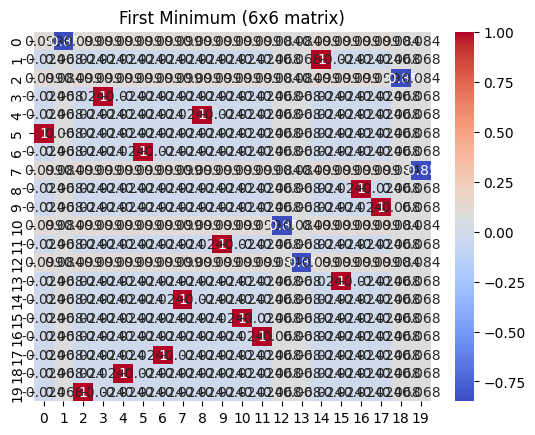

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(minima[:, :, 0], annot=True, cmap="coolwarm")
plt.title("First Minimum (6x6 matrix)")
plt.show()


In [ ]:
%matplotlib inline
norm_graph()

Exception: File "Processed minima k=50.p" not found

In [ ]:
def norm_graph():
    k_values = [20,50,100]
    data = []

    for k in k_values:
        try:
            with open(f"Processed minima k={k}.p", "rb") as file:
                minima = pickle.load(file)
        except (OSError, IOError):
            raise Exception(f'File "Processed minima k={k}.p" not found')

        norms = []
        for m in minima:
            if not np.array_equal(m.vals, np.array([1, 0])) and m.min_eig > 0:
                norms.extend([m.norm_sum] * m.multiplicity)
        data.append(np.array(norms))

    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(13, 6))

    for idx, ax in enumerate(axes):
        ax.hist(data[idx], bins=8, color='skyblue', edgecolor='black')
        ax.set_title(f'k={k_values[idx]}', fontsize=16)
        ax.set_xlabel('Sum of Euclidean norm of neurons', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.tick_params(labelsize=10)

    plt.tight_layout()
    plt.show()


In [ ]:
%matplotlib inline
norm_graph()

Exception: File "Processed minima k=50.p" not found

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Generate a simple dataset
X = np.linspace(-1, 1, 100).reshape(-1, 1)  # 100 data points between -1 and 1

# Create a simple teacher network (with 1 hidden layer of neurons)
def create_model(num_neurons):
    model = models.Sequential()
    model.add(layers.Dense(num_neurons, input_dim=1, activation='relu'))
    model.add(layers.Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mse')
    return model

# Create and train the teacher model
teacher_model = create_model(50)  # Teacher has 50 neurons
teacher_model.fit(X, X ** 2, epochs=200, verbose=0)  # Teacher generates y = X^2 dataset

# Use the trained teacher model to generate the target output (y) for the dataset
y_teacher_generated = teacher_model.predict(X)

# Now, create a student model with one more neuron than the teacher
student_model = create_model(51)  # Student has 51 neurons (1 extra)
student_model.fit(X, y_teacher_generated, epochs=200, verbose=0)  # Student learns from teacher-generated data

# Loss Landscape Visualization (For simplicity, just visualize the loss with respect to a single weight in the first layer)

# Generate predictions for teacher and student models over the grid
teacher_predictions = teacher_model.predict(X)
student_predictions = student_model.predict(X)

# Plot the loss landscape comparison
plt.figure(figsize=(10, 6))
plt.plot(X, teacher_predictions, label="Teacher Network (Generated Data)", color='blue')
plt.plot(X, student_predictions, label="Student Network (Learned from Teacher)", color='red')
plt.xlabel("Input (X)")
plt.ylabel("Predictions")
plt.title("Effect of Adding Extra Neuron on Loss Landscape (Teacher Generates Data)")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Generate a simple dataset
X = np.linspace(-1, 1, 100).reshape(-1, 1)  # 100 data points between -1 and 1

# Create a simple teacher network (with 1 hidden layer of neurons)
def create_model(num_neurons):
    model = models.Sequential()
    model.add(layers.Dense(num_neurons, input_dim=1, activation='relu'))
    model.add(layers.Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mse')
    return model

# Create and train the teacher model
teacher_model = create_model(50)  # Teacher has 50 neurons
teacher_model.fit(X, X ** 2, epochs=200, verbose=0)  # Teacher generates y = X^2 dataset

# Use the trained teacher model to generate the target output (y) for the dataset
y_teacher_generated = teacher_model.predict(X)

# Now, create a student model with one more neuron than the teacher
student_model = create_model(50)  # Student has 51 neurons (1 extra)
student_model.fit(X, y_teacher_generated, epochs=200, verbose=0)  # Student learns from teacher-generated data

# Loss Landscape Visualization (For simplicity, just visualize the loss with respect to a single weight in the first layer)

# Generate predictions for teacher and student models over the grid
teacher_predictions = teacher_model.predict(X)
student_predictions = student_model.predict(X)

# Plot the loss landscape comparison
plt.figure(figsize=(10, 6))
plt.plot(X, teacher_predictions, label="Teacher Network (Generated Data)", color='blue')
plt.plot(X, student_predictions, label="Student Network (Learned from Teacher)", color='red')
plt.xlabel("Input (X)")
plt.ylabel("Predictions")
plt.title("Effect of Adding Extra Neuron on Loss Landscape (Teacher Generates Data)")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Generate a simple dataset
X = np.linspace(-1, 1, 100).reshape(-1, 1)  # 100 data points between -1 and 1

# Create a simple teacher network (with 1 hidden layer of neurons)
def create_model(num_neurons):
    model = models.Sequential()
    model.add(layers.Dense(num_neurons, input_dim=1, activation='relu'))
    model.add(layers.Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mse')
    return model

# Create and train the teacher model
teacher_model = create_model(5)  # Teacher has 50 neurons
teacher_model.fit(X, X ** 2, epochs=200, verbose=0)  # Teacher generates y = X^2 dataset

# Use the trained teacher model to generate the target output (y) for the dataset
y_teacher_generated = teacher_model.predict(X)

# Now, create a student model with one more neuron than the teacher
student_model = create_model(5)  # Student has 51 neurons (1 extra)
student_model.fit(X, y_teacher_generated, epochs=200, verbose=0)  # Student learns from teacher-generated data

# Loss Landscape Visualization (For simplicity, just visualize the loss with respect to a single weight in the first layer)

# Generate predictions for teacher and student models over the grid
teacher_predictions = teacher_model.predict(X)
student_predictions = student_model.predict(X)

# Plot the loss landscape comparison
plt.figure(figsize=(10, 6))
plt.plot(X, teacher_predictions, label="Teacher Network (Generated Data)", color='blue')
plt.plot(X, student_predictions, label="Student Network (Learned from Teacher)", color='red')
plt.xlabel("Input (X)")
plt.ylabel("Predictions")
plt.title("Effect of Adding Extra Neuron on Loss Landscape (Teacher Generates Data)")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Generate a simple dataset
X = np.linspace(-1, 1, 100).reshape(-1, 1)  # 100 data points between -1 and 1

# Create a simple teacher network (with 1 hidden layer of neurons)
def create_model(num_neurons):
    model = models.Sequential()
    model.add(layers.Dense(num_neurons, input_dim=1, activation='relu'))
    model.add(layers.Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mse')
    return model

# Create and train the teacher model
teacher_model = create_model(5)  # Teacher has 50 neurons
teacher_model.fit(X, X ** 2, epochs=200, verbose=0)  # Teacher generates y = X^2 dataset

# Use the trained teacher model to generate the target output (y) for the dataset
y_teacher_generated = teacher_model.predict(X)

# Now, create a student model with one more neuron than the teacher
student_model = create_model(6)  # Student has 51 neurons (1 extra)
student_model.fit(X, y_teacher_generated, epochs=200, verbose=0)  # Student learns from teacher-generated data

# Loss Landscape Visualization (For simplicity, just visualize the loss with respect to a single weight in the first layer)

# Generate predictions for teacher and student models over the grid
teacher_predictions = teacher_model.predict(X)
student_predictions = student_model.predict(X)

# Plot the loss landscape comparison
plt.figure(figsize=(10, 6))
plt.plot(X, teacher_predictions, label="Teacher Network (Generated Data)", color='blue')
plt.plot(X, student_predictions, label="Student Network (Learned from Teacher)", color='red')
plt.xlabel("Input (X)")
plt.ylabel("Predictions")
plt.title("Effect of Adding Extra Neuron on Loss Landscape (Teacher Generates Data)")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Generate a simple dataset
X = np.linspace(-1, 1, 100).reshape(-1, 1)  # 100 data points between -1 and 1
# Use a more complex function for the teacher model's output (sinusoidal or polynomial)
y_teacher_generated = X**3 + X**2 + X  # Sinusoidal function: y = sin(2πx)
# Alternatively, for polynomial function:
# y_teacher_generated = X**3 + X**2 + X  # Polynomial function: y = x^3 + x^2 + x

# Create a simple teacher network (with 1 hidden layer of neurons)
def create_model(num_neurons):
    model = models.Sequential()
    model.add(layers.Dense(num_neurons, input_dim=1, activation='relu'))
    model.add(layers.Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mse')
    return model

# Create and train the teacher model
teacher_model = create_model(100)  # Teacher has 100 neurons
teacher_model.fit(X, y_teacher_generated, epochs=200, verbose=0)  # Teacher generates y = sin(2πx) dataset

# Use the trained teacher model to generate the target output (y) for the dataset
y_teacher_generated = teacher_model.predict(X)

# Now, create a student model with the same number of neurons as the teacher
student_model = create_model(10)  # Student has 100 neurons (same as teacher)
history_student = student_model.fit(X, y_teacher_generated, epochs=200, verbose=0)  # Student learns from teacher-generated data

# Now, create a student model with one more neuron than the teacher
student_model2 = create_model(11)  # Student has 101 neurons (1 extra)
history_student2 = student_model2.fit(X, y_teacher_generated, epochs=200, verbose=0)  # Student learns from teacher-generated data

# Loss Landscape Visualization (For simplicity, just visualize the loss with respect to the predictions)

# Generate predictions for teacher and student models over the grid
teacher_predictions = teacher_model.predict(X)
student_predictions = student_model.predict(X)
student_predictions2 = student_model2.predict(X)

# Plot the predictions from Teacher, Student, and Student2
plt.figure(figsize=(10, 6))
plt.plot(X, teacher_predictions, label="Teacher Network (Generated Data)", color='blue')
plt.plot(X, student_predictions, label="Student Network (Learned from Teacher)", color='red')
plt.plot(X, student_predictions2, label="Student 2 Network (Learned from Teacher)", color='green')

plt.xlabel("Input (X)")
plt.ylabel("Predictions")
plt.title("Effect of Adding Extra Neuron on Loss Landscape (Teacher Generates Data)")
plt.legend()
plt.grid(True)
plt.show()

# Plot the loss curves for Student and Student 2
plt.figure(figsize=(10, 6))
plt.plot(history_student.history['loss'], label="Student Loss (100 neurons)", color='red')
plt.plot(history_student2.history['loss'], label="Student 2 Loss (101 neurons)", color='green')

plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss Comparison between Student and Student 2 Models")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
!pip install losscape

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Import losscape
from losscape.train import train
from losscape.create_landscape import create_2D_losscape

# Define a simple model
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(1, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleNet()

# Create dummy dataset
X = torch.linspace(-1, 1, 100).unsqueeze(1)
y = torch.sin(2 * torch.pi * X)
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Train the model (or use your own training loop)
train(model, train_loader, epochs=10)

# Now create the 2D loss landscape
create_2D_losscape(model, train_loader)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Create synthetic data
torch.manual_seed(0)
n_samples = 300
X = torch.randn(n_samples, 20)
true_w = torch.randn(20, 1)
y = X @ true_w + 0.1 * torch.randn(n_samples, 1)

# Split into train and test
train_X, test_X = X[:200], X[200:]
train_y, test_y = y[:200], y[200:]

# Define a function to create and train a model
def train_model(hidden_size):
    model = nn.Sequential(
        nn.Linear(20, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 1)
    )
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Train
    for epoch in range(300):
        model.train()
        pred = model(train_X)
        loss = loss_fn(pred, train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute train and test loss
    model.eval()
    with torch.no_grad():
        train_loss = loss_fn(model(train_X), train_y).item()
        test_loss = loss_fn(model(test_X), test_y).item()

    return train_loss, test_loss

# Try different hidden layer sizes
hidden_sizes = [1, 10,100,1000,10000,100000,1000000,10000000]
train_losses = []
test_losses = []

for size in hidden_sizes:
    train_loss, test_loss = train_model(size)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(hidden_sizes, train_losses, label='Train Loss', marker='o')
plt.plot(hidden_sizes, test_losses, label='Test Loss', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Hidden Layer Size (log scale)')
plt.ylabel('MSE Loss (log scale)')
plt.title('Effect of Overparameterization')
plt.legend()
plt.grid(True)
plt.show()
